In [30]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed
random.seed(42)
torch.manual_seed(42)

# Update paths here
indoor_dir = "/Users/admin/Downloads/Training/museum-indoor"
outdoor_dir = "/Users/admin/Downloads/Training/museum-outdoor"
# Define your test directories
indoor_test_dir = "/Users/admin/Downloads/Museum_Validation/museum-indoor"
outdoor_test_dir = "/Users/admin/Downloads/Museum_Validation/museum-outdoor"

image_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load image paths and assign labels
def load_dataset(indoor_dir, outdoor_dir):
    image_paths, labels = [], []
    for file in os.listdir(indoor_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(indoor_dir, file))
            labels.append(0)
    for file in os.listdir(outdoor_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(outdoor_dir, file))
            labels.append(1)
    return image_paths, labels

# Load test dataset from folder structure
def load_test_dataset(indoor_dir, outdoor_dir, transform):
    test_paths = []
    test_labels = []

    for file in os.listdir(indoor_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(indoor_dir, file))
            test_labels.append(0)  # Indoor

    for file in os.listdir(outdoor_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(outdoor_dir, file))
            test_labels.append(1)  # Outdoor

    return test_paths, test_labels

# Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


In [32]:
# CNN model
class CNNModel(nn.Module):
    def __init__(self, num_conv_layers, dropout_rate):
        super(CNNModel, self).__init__()
        layers = []
        in_channels = 3
        out_channels = 16
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
            out_channels *= 2
        self.features = nn.Sequential(*layers)
        flat_size = (image_size // (2 ** num_conv_layers)) ** 2 * in_channels
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [34]:
# Train model
def train_validate(model, train_loader, val_loader, lr, device, epochs=2):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    # Validation
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets.numpy())
    return accuracy_score(all_targets, all_preds)

# Load and split dataset
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])
image_paths, labels = load_dataset(indoor_dir, outdoor_dir)
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)
train_data = ImageDataset(X_train, y_train, transform)
val_data = ImageDataset(X_val, y_val, transform)

In [36]:
# Set number of epochs for tuning phase
tuning_epochs = 2

# Define hyperparameter grid
param_grid = {
    "num_conv_layers": [2, 3],
    "dropout_rate": [0.3, 0.5],
    "lr": [0.01, 0.001],
    "batch_size": [64, 128]
}

# Store best results
best_score = 0
best_params = {}

# Grid search over all combinations
for n in param_grid["num_conv_layers"]:
    for d in param_grid["dropout_rate"]:
        for lr in param_grid["lr"]:
            for b in param_grid["batch_size"]:
                print(f"\n Trying: Conv Layers = {n}, Dropout = {d}, LR = {lr}, Batch Size = {b}")

                # Create data loaders
                train_loader = DataLoader(train_data, batch_size=b, shuffle=True)
                val_loader = DataLoader(val_data, batch_size=b)

                # Create and train model
                model = CNNModel(n, d)
                accuracy = train_validate(model, train_loader, val_loader, lr, device, epochs=tuning_epochs)
                print(f" Validation Accuracy: {accuracy:.4f}")

                # Update best score
                if accuracy > best_score:
                    best_score = accuracy
                    best_params = {
                        "num_conv_layers": n,
                        "dropout_rate": d,
                        "lr": lr,
                        "batch_size": b
                    }

print("\n Best Hyperparameters Found:")
for k, v in best_params.items():
    print(f"{k}: {v}")
print(f"Best Validation Accuracy: {best_score:.4f}")




 Trying: Conv Layers = 2, Dropout = 0.3, LR = 0.01, Batch Size = 64
 Validation Accuracy: 0.8915

 Trying: Conv Layers = 2, Dropout = 0.3, LR = 0.01, Batch Size = 128
 Validation Accuracy: 0.8965

 Trying: Conv Layers = 2, Dropout = 0.3, LR = 0.001, Batch Size = 64
 Validation Accuracy: 0.9055

 Trying: Conv Layers = 2, Dropout = 0.3, LR = 0.001, Batch Size = 128
 Validation Accuracy: 0.8930

 Trying: Conv Layers = 2, Dropout = 0.5, LR = 0.01, Batch Size = 64
 Validation Accuracy: 0.8915

 Trying: Conv Layers = 2, Dropout = 0.5, LR = 0.01, Batch Size = 128
 Validation Accuracy: 0.9040

 Trying: Conv Layers = 2, Dropout = 0.5, LR = 0.001, Batch Size = 64
 Validation Accuracy: 0.9065

 Trying: Conv Layers = 2, Dropout = 0.5, LR = 0.001, Batch Size = 128
 Validation Accuracy: 0.9010

 Trying: Conv Layers = 3, Dropout = 0.3, LR = 0.01, Batch Size = 64
 Validation Accuracy: 0.8970

 Trying: Conv Layers = 3, Dropout = 0.3, LR = 0.01, Batch Size = 128
 Validation Accuracy: 0.9000

 Trying: C

In [38]:

# Train best model for 10 epochs
print("\n Training Best Model for 10 Epochs...")

# Re-initialize model and loaders with best hyperparameters
best_model = CNNModel(
    num_conv_layers=best_params["num_conv_layers"],
    dropout_rate=best_params["dropout_rate"]
).to(device)

train_loader = DataLoader(train_data, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=best_params["batch_size"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params["lr"])

for epoch in range(10):
    best_model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluation after each epoch
    best_model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            outputs = best_model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets.numpy())

    acc = accuracy_score(all_targets, all_preds)
    print(f" Epoch {epoch+1}/10 — Validation Accuracy: {acc:.4f}")

# Save the trained model
torch.save(best_model.state_dict(), "best_model.pkl")
print("\n Model saved successfully as 'best_model.pkl'")



 Training Best Model for 10 Epochs...
 Epoch 1/10 — Validation Accuracy: 0.8885
 Epoch 2/10 — Validation Accuracy: 0.8965
 Epoch 3/10 — Validation Accuracy: 0.9085
 Epoch 4/10 — Validation Accuracy: 0.9075
 Epoch 5/10 — Validation Accuracy: 0.9085
 Epoch 6/10 — Validation Accuracy: 0.9095
 Epoch 7/10 — Validation Accuracy: 0.9085
 Epoch 8/10 — Validation Accuracy: 0.9160
 Epoch 9/10 — Validation Accuracy: 0.9180
 Epoch 10/10 — Validation Accuracy: 0.9125

 Model saved successfully as 'best_model.pkl'


Test Accuracy on Museum_Validation: 0.8900
Accuracy: 0.8900
Precision: 0.9062
Recall: 0.8700
F1-score: 0.8878

              precision    recall  f1-score   support

      Indoor       0.88      0.91      0.89       100
     Outdoor       0.91      0.87      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



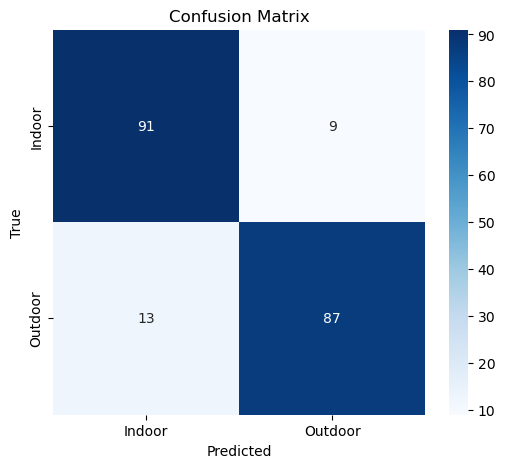

In [40]:
# Load model and evaluate
def load_model_and_test_folder(indoor_dir, outdoor_dir, model_path, transform):
    image_paths, labels = load_test_dataset(indoor_dir, outdoor_dir, transform)
    dataset = ImageDataset(image_paths, labels, transform)
    loader = DataLoader(dataset, batch_size=32)

    # Load the best model
    model = CNNModel(
        num_conv_layers=best_params["num_conv_layers"],
        dropout_rate=best_params["dropout_rate"]
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)

    # Accuracy
    acc = accuracy_score(labels, predictions)
    print(f"Test Accuracy on Museum_Validation: {acc:.4f}")

    evaluate_predictions(labels, predictions)

def evaluate_predictions(true_labels, predicted_labels, class_names=["Indoor", "Outdoor"]):
    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}\n")

    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Run it
load_model_and_test_folder(indoor_test_dir, outdoor_test_dir, "best_model.pkl", transform)
